In [1]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)

48

# imports


In [2]:
import fluxes as fx
from collections import namedtuple
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2

from fluxes import atmo_background, astro_flux
from aeff_calculations import calc_aeff_factor
from settings import ngc1068
from tools import get_mids
from scipy.interpolate import RegularGridInterpolator

from settings import BASEPATH
import settings as st
from os.path import join
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use(join(BASEPATH, "style.mplstyle"))
warnings.filterwarnings("ignore")

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [3]:
import astropy.units as u

In [6]:
V_TRIDENT = 7.5 * u.km**3
h_TRIDENT = 0.6 * u.km
R_TRIDENT = 2 * u.km

V_NEON = 10 * u.km**3
h_NEON = 1 * u.km
R_NEON = 1.8 * u.km

V_HUNT = 30 * u.km**3
h_HUNT = 0.86 * u.km
R_HUNT = 3 * u.km

In [35]:
V_IC = 1 * u.km**3
h_IC = 1 * u.km


V_IC2 = 8 * u.km**3
h_IC2 = 1 * u.km

In [20]:
def projected_area(V=None, h=None, R=None):
    if h is None:
        h = V/np.pi/(R**2)
        print("Height", h)
    elif R is None:
        R = np.sqrt(V/np.pi/h)
        print("Radius", R)
    elif V is None:
        V = np.pi*R**2 * h
        print("Volume", V)
    
    return V/2 * (1/h + 1/R)

In [34]:
IC_AP = projected_area(V=V_IC, h=h_IC)
IC_AP

Radius 0.5641895835477563 km


<Quantity 1.38622693 km2>

In [38]:
scale = 7.5 / (projected_area(V=V_IC2, h=h_IC2)/IC_AP)


Radius 1.5957691216057308 km


In [39]:
projected_area(V=V_IC2, h=h_IC2)/IC_AP * scale


Radius 1.5957691216057308 km


<Quantity 7.5>

In [40]:
projected_area(V=V_TRIDENT, h=h_TRIDENT)/IC_AP * scale

Radius 1.9947114020071635 km


<Quantity 9.37117989>

In [41]:
projected_area(V=V_NEON, h=h_NEON)/IC_AP * scale #, R=R_NEON

Radius 1.7841241161527712 km


<Quantity 8.99370835>

In [42]:
projected_area(V=V_HUNT, h=h_HUNT) / IC_AP * scale

Radius 3.3322414736884607 km


<Quantity 25.29344005>

# loading effective areas


In [52]:
from aeff_calculations import get_aeff_and_binnings

In [53]:
aeff_2d, ic_logebins, _, ic_sindecbins = get_aeff_and_binnings("upgoing")

In [51]:
sindec_bins, logE_bins, aeffs = pd.read_pickle(
    join(st.LOCALPATH, "trident_numu_aeff_with-eq.pckl")
)


In [70]:
NEON_aeff = 30E4 # cm^2 horizon E=10TeV
NEON_aeff / aeff_2d["IceCube"][np.isclose(ic_logebins[:-1], 4)].T[
    ic_sindecbins[:-1] == 0
]

array([[3.26646105]])

In [67]:
aeff_2d["IceCube"][
    np.isclose(ic_logebins[:-1], 3)
    | np.isclose(ic_logebins[:-1], 4)
    | np.isclose(ic_logebins[:-1], 5)
    | np.isclose(ic_logebins[:-1], 6)
    | np.isclose(ic_logebins[:-1], 6.9)
].T[ic_sindecbins[:-1] == 0] / aeffs["local"][
    (logE_bins[:-1] == 3)
    | (logE_bins[:-1] == 4)
    | (logE_bins[:-1] == 5)
    | (logE_bins[:-1] == 6)
    | (logE_bins[:-1] == 6.9)
].T[
    sindec_bins[:-1] == 0
]

array([[0.05795634, 0.10605808, 0.17346333, 0.22979545, 0.31011379]])

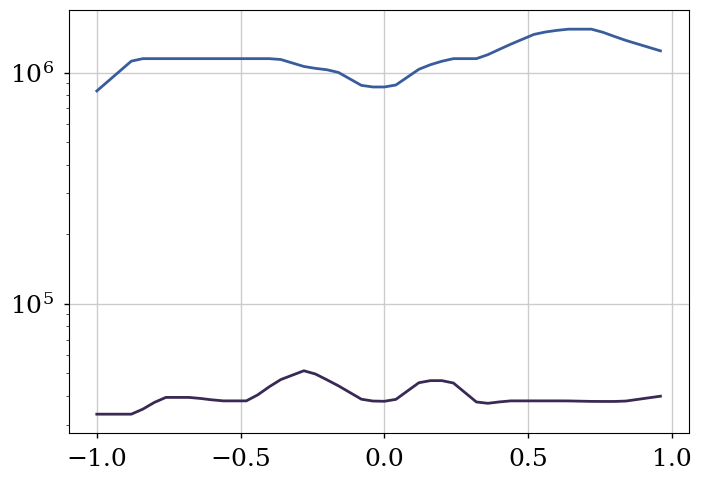

In [32]:
plt.plot(
    sindec_bins[:-1], aeffs["local"][(logE_bins[:-1] == 4) | (logE_bins[:-1] == 3)].T
)
plt.yscale("log")

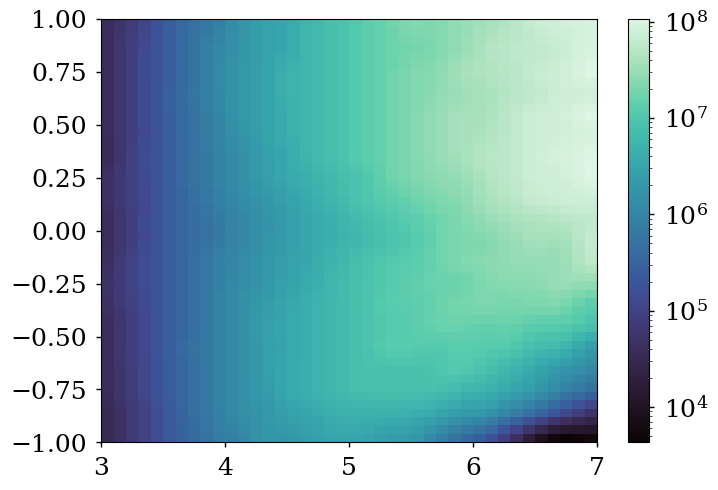

In [19]:
plt.pcolormesh(logE_bins, sindec_bins, aeffs["local"].T, norm=LogNorm())
plt.colorbar()

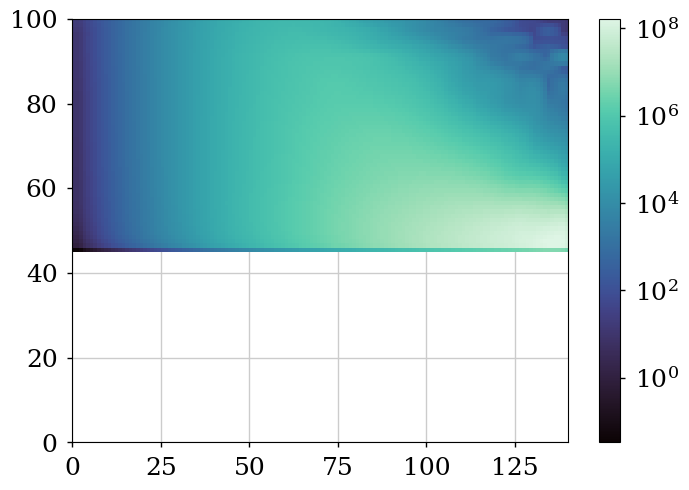

In [20]:
plt.pcolormesh(aeff_2d["IceCube"].T, norm=LogNorm())
plt.colorbar()

## binning

In [4]:
aeff_test = aeffs["equatorial"]
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
50 declination bins


# background

In [5]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_total"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

# astro flux source parameters

In [6]:
# livetime of 1yr in seconds
LIVETIME_1yr = 365 * 24 * 3600
# diffuse flux
from aeff_calculations import aeff_eval_e_sd
from settings import E_NORM, PHI_ASTRO, GAMMA_ASTRO

print(PHI_ASTRO)
print(GAMMA_ASTRO)


1.44e-18
2.37


In [7]:
diff_config = {
    "diff_or_ps": "diff",
    "sindec_width": sindec_width,
    "ewidth": ewidth,
    "livetime": LIVETIME_1yr

}

# Flux definition

In [8]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## calculate number of events for diffuse flux

In [10]:
n_events = []
flux_def = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")
aeff_factor = (aeffs["equatorial"] * sindec_width).T * ewidth * 2 * np.pi * LIVETIME_1yr
k_s = astro_flux(
    aeff_factor,
    emids,
    normed_kvals=None,
    phi_scaling=1,
    flux_shape=flux_def,
)
print(np.sum(k_s))

k_b = atmo_background(
    aeff_factor,
    spl_vals,
)
print(np.sum(k_b))


5522.409366451537
697949.3351083333


# Energy and sindec resolution

In [11]:
# energy smearing matrix
with open("../../resources/trident_muon_energy_smearing_2D_10-res.pckl", "rb") as f:
    reso, new_logE_bins, new_logE_reco_bins = pickle.load(f)
new_logE_reco_mids = get_mids(new_logE_reco_bins)
new_logE_mids = get_mids(new_logE_bins)
# normalize per bin in true energy

rgi = RegularGridInterpolator((new_logE_reco_mids, new_logE_mids), reso)

# new binning
logE_reco_bins = np.arange(2.9, 7.05, step=0.1)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
energy_resolution = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
energy_resolution = energy_resolution / np.sum(energy_resolution, axis=0)

Text(0.5, 0, 'log10(E_true)')

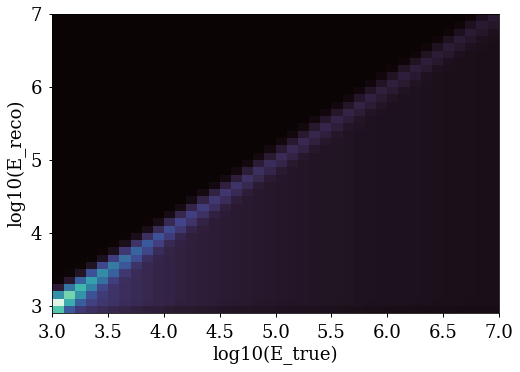

In [12]:
plt.pcolormesh(logE_bins, logE_reco_bins, energy_resolution)
plt.ylabel("log10(E_reco)")
plt.xlabel("log10(E_true)")

# simple diffuse fit

## llh definition

In [13]:
def diffuse_llh_2d_composite(
    x,
    mu_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    spl_vals=spl_vals,
    plot_this=False,  # only for plotting
    ereco=None,  # only for plotting
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_base * x[0],
        spl_vals,
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        mu_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    mu_i = mu_s + mu_b
    if plot_this:
        f, axes = plt.subplots(ncols=2, figsize=(12, 6))
        axes[0].plot(ereco, mu_s.sum(axis=0), ls="-", label="mu_s", ds="steps-mid")
        axes[0].plot(ereco, mu_b.sum(axis=0), ls="--", label="mu_b", ds="steps-mid")
        axes[0].set_yscale("log")
        axes[0].legend()
        axes[0].set_title("ereco from llh function")

        sdm = np.linspace(-1, 1, len(mu_s))
        axes[1].plot(sdm, mu_s.sum(axis=1), ls="-", label="mu_s", ds="steps-mid")
        axes[1].plot(sdm, mu_b.sum(axis=1), ls="--", label="mu_b", ds="steps-mid")
        axes[1].set_title("sindec from llh function")

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# diffuse vs uniform atmospheric

## checks with plotting

out comp (array([0.99999996, 1.00000159, 2.37000196]), 6259.458380546092, {'grad': array([0.01573426, 0.00909495, 0.00627551]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 288, 'nit': 32, 'warnflag': 0})
out bg (array([1.00791232]), 6607.838529991739, {'grad': array([-0.01109584]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 12, 'nit': 3, 'warnflag': 0})
- - - - - - - - - - 


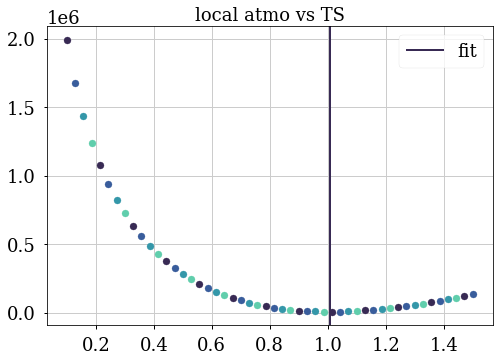

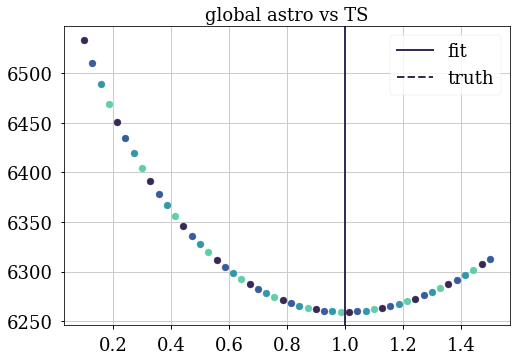

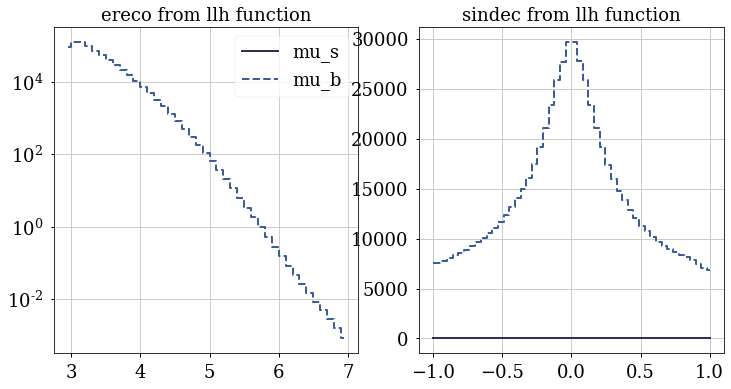

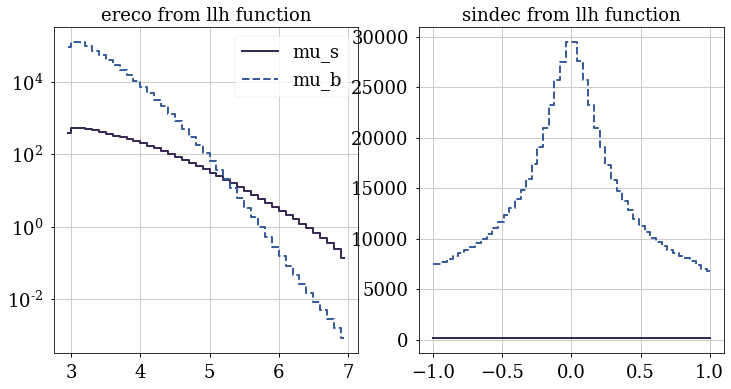

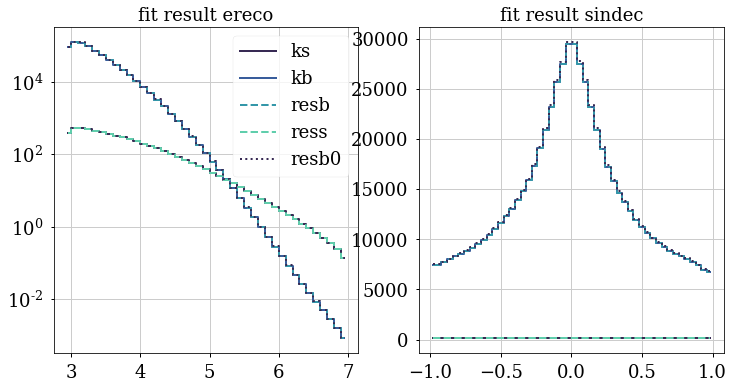

In [16]:
atmo_range = np.linspace(0.1, 1.5, num=50)
astro_range = np.linspace(0.1, 1.5, num=50)
gamma_range = np.linspace(1, 4, num=20)

diff_significances = []
aeff_factor = calc_aeff_factor(aeff_test, **diff_config)
k_s = astro_flux(
    aeff_factor,
    emids,
    normed_kvals=energy_resolution,
    phi_scaling=1,
    flux_shape=flux_def,
)
k_b = atmo_background(
    aeff_factor,
    spl_vals,
    normed_kvals=energy_resolution,
)

k_i = k_s + k_b

# fix signal contribution to 0
fit_config = dict(
    mu_base=aeff_factor,
    k_i=k_i,
    e_0=E_NORM,
    phi_0=PHI_ASTRO,
    shape="powerlaw",
    normed_kvals=energy_resolution,
)
local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    bounds=[(1e-3, 1e2)],
    approx_grad=True,
)

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.1, 1.1, GAMMA_ASTRO+0.1),
    bounds=[(1e-1, 1e1), (1e-1, 1e1), (1.0, 4.0)],
    approx_grad=True,
    factr=10,
)

if True:
    print("out comp", out_comp)
    print("out bg", out_bckg)

    # show llh space
    plt.figure()
    plt.title("local atmo vs TS")
    for ar in atmo_range:
        check_bg = local_llh((ar,))
        plt.scatter(ar, check_bg)
    plt.axvline(out_bckg[0][0], label="fit")
    plt.legend()

    plt.figure()
    plt.title("global astro vs TS")
    for ar in astro_range:
        check = global_llh((1, ar, GAMMA_ASTRO))
        plt.scatter(ar, check)
    plt.axvline(out_comp[0][1], label="fit")
    plt.axvline(1, label="truth", ls="--")
    plt.legend()

    # plot the fit result using the llh function
    diffuse_llh_2d_composite(
        (out_bckg[0][0], 0, 2), **fit_config, plot_this=True, ereco=logE_reco_mids
    )
    diffuse_llh_2d_composite(
        out_comp[0], **fit_config, plot_this=True, ereco=logE_reco_mids
    )

    # cross-check with manual plotting
    res_s = astro_flux(
        aeff_factor,
        emids,
        normed_kvals=energy_resolution,
        phi_scaling=1,
        flux_shape=fx.PL_flux(
            out_comp[0][1] * PHI_ASTRO, out_comp[0][2], E_NORM, "powerlaw"
        ),
    )
    res_b = k_b * out_comp[0][0]
    res_b_0 = k_b * out_bckg[0][0]

    # show plots of fit results as check
    f, axes = plt.subplots(ncols=2, figsize=(12, 6))
    axes[0].plot(
        logE_reco_mids,
        k_s.sum(axis=0),
        ls="-",
        label="ks",
        ds="steps-mid",
    )
    axes[0].plot(
        logE_reco_mids,
        k_b.sum(axis=0),
        ls="-",
        label="kb",
        ds="steps-mid",
    )
    axes[0].plot(
        logE_reco_mids,
        res_b.sum(axis=0),
        ls="--",
        label="resb",
        ds="steps-mid",
    )
    axes[0].plot(
        logE_reco_mids,
        res_s.sum(axis=0),
        ls="--",
        label="ress",
        ds="steps-mid",
    )
    axes[0].plot(
        logE_reco_mids,
        res_b_0.sum(axis=0),
        ls=":",
        label="resb0",
        ds="steps-mid",
    )
    axes[0].set_yscale("log")
    axes[0].legend()
    axes[0].set_title("fit result ereco")

    axes[1].plot(sindec_mids, k_s.sum(axis=1), ls="-", label="ks", ds="steps-mid")
    axes[1].plot(sindec_mids, k_b.sum(axis=1), ls="-", label="kb", ds="steps-mid")
    axes[1].plot(
        sindec_mids, res_b.sum(axis=1), ls="--", label="resb", ds="steps-mid"
    )
    axes[1].plot(
        sindec_mids, res_s.sum(axis=1), ls="--", label="ress", ds="steps-mid"
    )
    axes[1].plot(
        sindec_mids, res_b_0.sum(axis=1), ls=":", label="resb0", ds="steps-mid"
    )
    axes[1].set_title("fit result sindec")

    print("- " * 10)
    # raise BaseException(">:O")


## fitting

In [15]:
for i in np.arange(0.1, 1.1, step=0.1):
    aeff_factor = calc_aeff_factor(aeff_test, **diff_config)
    aeff_factor *= i
    print(i, "years:")
    k_s = astro_flux(
        aeff_factor,
        emids,
        normed_kvals=energy_resolution,
        phi_scaling=1,
        flux_shape=flux_def,
    )
    k_b = atmo_background(
        aeff_factor,
        spl_vals,
        normed_kvals=energy_resolution,
    )

    k_i = k_s + k_b

    # fix signal contribution to 0
    fit_config = dict(
        mu_base=aeff_factor,
        k_i=k_i,
        e_0=E_NORM,
        phi_0=PHI_ASTRO,
        shape="powerlaw",
        normed_kvals=energy_resolution,
    )
    local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
    global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        bounds=[(1e-3, 1e2)],
        approx_grad=True,
    )

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.1, 1.1, GAMMA_ASTRO+0.1),
        bounds=[(1e-1, 1e1), (1e-1, 1e1), (1.0, 4.0)],
        approx_grad=True,
        factr=10,
    )

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print(pval, significance)

0.1 years:
2.722834069132587e-08 5.558384267681442
0.2 years:
7.413825417162481e-16 8.041399959096541
0.30000000000000004 years:
2.0186616220202606e-23 inf
0.4 years:
5.496480585742541e-31 inf
0.5 years:
1.4966004627395532e-38 inf
0.6 years:
4.074994801720796e-46 inf
0.7000000000000001 years:
1.109553433544121e-53 inf
0.8 years:
3.0211298885127182e-61 inf
0.9 years:
8.226035641718877e-69 inf
1.0 years:
2.2398129204518867e-76 inf


# PS

In [47]:
psi2_all, _, psi2_bins = pd.read_pickle(
    f"../../resources/trident_muon_psi_2D.pckl",
)
bckg_grid = np.ones_like(psi2_all)
bckg_grid /= np.sum(bckg_grid, axis=0)


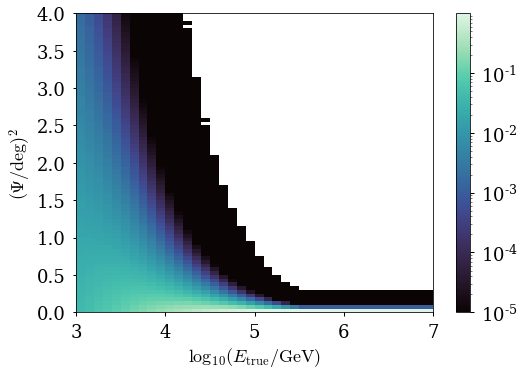

In [48]:
plt.figure()
plt.pcolormesh(logE_bins, psi2_bins, psi2_all, norm=LogNorm(vmin=1e-5))
plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")
plt.ylabel(r"$(\Psi / {\rm deg})^2$")
plt.colorbar()


In [49]:
from copy import copy

In [50]:
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5e-14
E0_NGC = 1e3


In [52]:
delta_psi = psi2_bins[-1] # max psi² range
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME_1yr,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=1,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi
bg_config["grid_2d"] = 1

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


src_config["grid_2d"] = psi2_all
ngc_src_config["grid_2d"] = psi2_all

bg_config["grid_2d"] = bckg_grid
ngc_bg_config["grid_2d"] = bckg_grid


In [53]:
from aeff_calculations import (
    get_energy_psf_grid,
    calc_aeff_factor,
    get_aeff_and_binnings,
    array_source_interp
)
from collections import namedtuple

In [54]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")

In [55]:
n_events = []
for dec in np.arcsin(sindec_mids):
    dct = {"src_dec": dec, "src_sindec": np.sin(dec)}
    src_config["dec"] = dec
    aeff_factor_signal = calc_aeff_factor(aeffs["equatorial"], **src_config)
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        normed_kvals=None, # no smearing here
        phi_scaling=1,
        flux_shape=ngc_flux
    )
    dct["n_sig"] = np.sum(k_s)

    aeff_factor_bckg = calc_aeff_factor(aeffs["equatorial"], **ngc_bg_config)
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(dec, spl_vals.T, sindec_mids).T,
        normed_kvals=None,
    )
    dct["n_bg"] = np.sum(k_b)
    dct["s/sqb"] = dct["n_sig"] / np.sqrt(dct["n_bg"])
    n_events.append(dct)
n_events = pd.DataFrame(n_events)


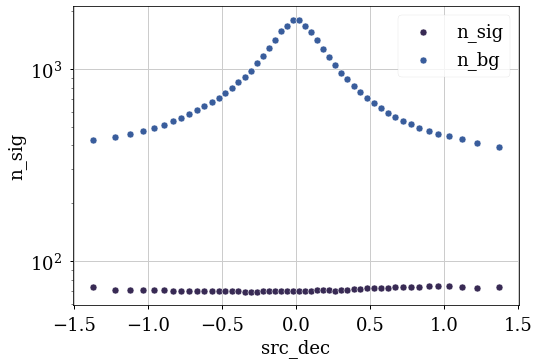

In [56]:
ax = sns.scatterplot(
    data=n_events, x="src_dec", y="n_sig", palette="crest", label="n_sig"
)
ax = sns.scatterplot(
    data=n_events, x="src_dec", y="n_bg", palette="crest", label="n_bg"
)
ax.set_yscale("log")

## ps llh definition

In [57]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# Fit

source: NGC 1068
Asimov data sum: Background= 1797.3846293448848 , Signal: 70.11948951549702
Atmo-only normalization: [1.03901197]
Signal fit parameters: [1.00000824 0.99956279 3.19982502]
-2 Delta LLH: 9.776506571024584
P-VALUE: 0.007534571733255256 SIGNIFICANCE: 2.6722445463431606



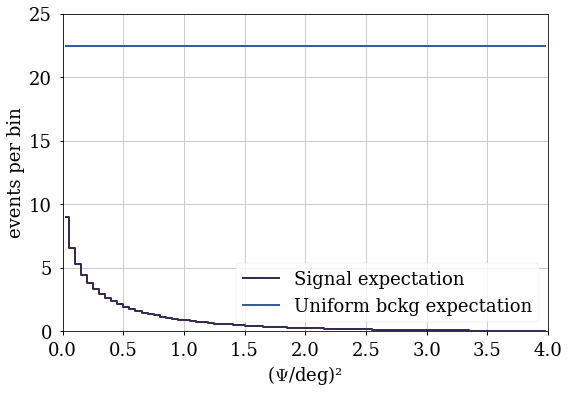

In [63]:
print("source: NGC 1068")
aeff_factor_bckg = calc_aeff_factor(aeffs["equatorial"], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeffs["equatorial"], **ngc_src_config)

# asimov data
k_b = atmo_background(
    aeff_factor_bckg,
    array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
    normed_kvals=energy_resolution,
)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    phi_scaling=1,
    normed_kvals=energy_resolution,
    flux_shape=ngc_flux,  # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum: Background=", np.sum(k_b), ", Signal:", np.sum(k_s))
# fix signal contribution to 0
fit_config = dict(
    shape="powerlaw",
    mu_b_base=k_b,
    mu_s_base=aeff_factor_signal,
    k_i=k_i,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    normed_kvals=energy_resolution,
)
local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **fit_config)
global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 1.2, 3.0),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
print("")

psi2_mids = get_mids(psi2_bins)
plt.figure()
plt.plot(psi2_mids, np.sum(k_s, axis=-1), ds="steps-mid", label="Signal expectation")
plt.plot(
    psi2_mids, np.sum(k_b, axis=-1), ds="steps-mid", label="Uniform bckg expectation"
)
plt.xlabel(r"($\Psi$/deg)²")
plt.ylabel("events per bin")
plt.xlim(0, delta_psi)
plt.ylim(0, 25)
plt.legend()
plt.tight_layout()
